# Edge detection
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YoniChechik/AI_is_Math/blob/master/c_03_edge_detection/edge_detection.ipynb)



In [1]:
# to run in google colab
import sys

if "google.colab" in sys.modules:
    import subprocess

    subprocess.call("apt-get install subversion".split())
    subprocess.call(
        "svn export https://github.com/YoniChechik/AI_is_Math/trunk/c_03_edge_detection/Bikesgray.jpg".split()
    )

# save plotly as html frames
import plotly.io as pio

if (pio.renderers.default != "vscode") & (pio.renderers.default != "colab"):
    pio.renderers.default = "iframe_connected"


In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import plotly.express as px

figsize = (10, 10)



## Original image


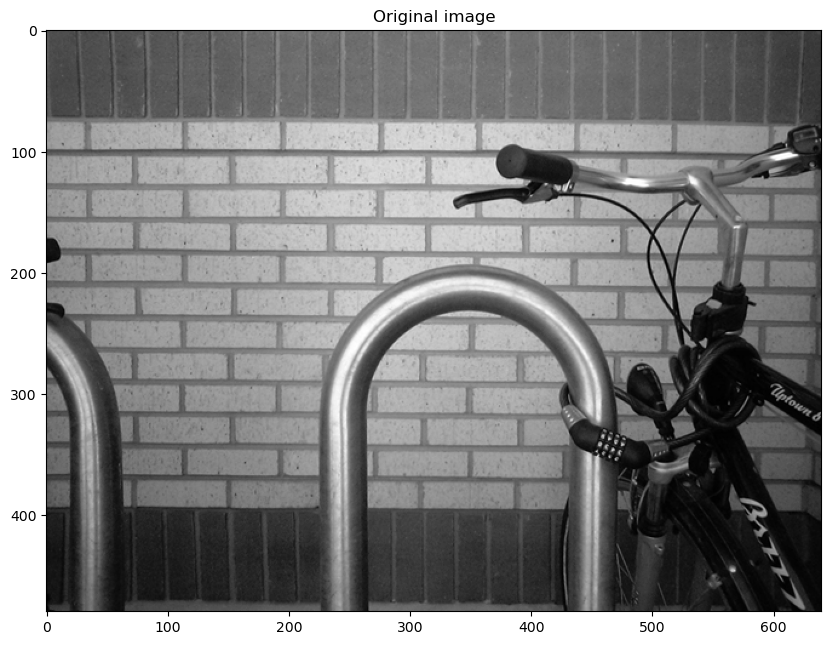

In [3]:
img = cv2.imread("Bikesgray.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=figsize)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.title("Original image")
plt.show()




## Magnitude and phase images



In [4]:
img = img.astype(float)

kernel = 1 / 8 * np.array([[-1, 0, +1], [-2, 0, +2], [-1, 0, +1]])
sobel_x = cv2.filter2D(img, -1, kernel)

kernel = kernel.T
sobel_y = cv2.filter2D(img, -1, kernel)

mag_img = np.sqrt(sobel_x ** 2 + sobel_y ** 2)

phase_img = cv2.phase(sobel_x, -sobel_y, angleInDegrees=True)

phase_img_masked = -100 * np.ones(phase_img.shape)
TH_PRC = 0.15
th = mag_img.max() * TH_PRC
phase_img_masked = phase_img_masked * (mag_img <= th) + phase_img * (mag_img > th)


px.imshow(mag_img, title="Gradient magnitude")


In [5]:
px.imshow(phase_img_masked, title="Gradient phase thresholeded")



## Edge thinning
### LoG filter
One way to implement edge thinning is to use LoG and then zero crossing finder.
Below is an example of abs LoG. Look at the handlebar to see the zero crossings.


In [6]:
kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
dst_LoG = cv2.filter2D(img, -1, kernel)

px.imshow(np.abs(dst_LoG), title="abs LoG")



## NMS
Non maximum suppression (NMS) is another way for edge thinning.
### NMS preliminary step: Quantizing the phase image



In [7]:
phase_img_q = phase_img.copy()
for i in range(mag_img.shape[0]):
    for j in range(mag_img.shape[1]):
        phase_img_q[i, j] = np.mod(phase_img_q[i, j] + 22.5, 180)
        phase_img_q[i, j] = (phase_img_q[i, j]) // 45  # integer devider

phase_img_q_masked = -1 * np.ones(phase_img.shape)
TH_PRC = 0.1
th = mag_img.max() * TH_PRC
phase_img_q_masked = phase_img_q_masked * (mag_img <= th) + phase_img_q * (mag_img > th)

px.imshow(phase_img_q_masked, title="Gradient phase- quantized and thresholded")




### NMS main step



In [8]:
nms = mag_img.copy()

for i in range(1, mag_img.shape[0] - 1):
    for j in range(1, mag_img.shape[1] - 1):
        if phase_img_q[i, j] == 0 and (mag_img[i, j + 1] > mag_img[i, j] or mag_img[i, j - 1] > mag_img[i, j]):
            nms[i, j] = -50
        if phase_img_q[i, j] == 1 and (mag_img[i + 1, j - 1] > mag_img[i, j] or mag_img[i - 1, j + 1] > mag_img[i, j]):
            nms[i, j] = -50
        if phase_img_q[i, j] == 2 and (mag_img[i - 1, j] > mag_img[i, j] or mag_img[i + 1, j] > mag_img[i, j]):
            nms[i, j] = -50
        if phase_img_q[i, j] == 3 and (mag_img[i - 1, j - 1] > mag_img[i, j] or mag_img[i + 1, j + 1] > mag_img[i, j]):
            nms[i, j] = -50

px.imshow(nms, title="NMS")



## double TH



In [9]:
nms_th = np.zeros(nms.shape)
TH_l = 3
TH_h = 13
nms_th[nms >= TH_h] = 2
nms_th[np.bitwise_and(TH_l <= nms, nms < TH_h)] = 1

px.imshow(nms_th, title="double TH")



## Iterative hysteresis
We will do the iterative process with connected components (CC):
1. Take a mask of combined weak and strong edges and run CC algorithm on it.
2. For each such CC group- test if there is intersection with ONLY strong edges mask.
3. If intersection exist, then weak edges in CC group is actually strong edges, so unite the masks.



In [10]:

nms_weak_and_strong = np.zeros(nms_th.shape, dtype=bool)
nms_strong = np.zeros(nms_th.shape, dtype=bool)

nms_weak_and_strong[nms_th > 0] = 1
nms_strong[nms_th == 2] = 1

num_w_s_CCs, w_s_CC_mask = cv2.connectedComponents(nms_weak_and_strong.astype(np.uint8))

# for each CC group of weak and strong edge mask
for w_s_CC_i in range(1, num_w_s_CCs):

    # get MASK of weak_and_strong edge from index w_s_CC_i
    w_s_CC_mask_i = np.zeros(nms_th.shape, dtype=bool)
    w_s_CC_mask_i[w_s_CC_mask == w_s_CC_i] = 1

    # if w_s_CC_mask_i has intersection with strong edges mask, add to strong edge mask
    if np.any(np.bitwise_and(w_s_CC_mask_i, nms_strong)):
        nms_strong = np.bitwise_or(w_s_CC_mask_i, nms_strong)

px.imshow(nms_strong, title="Canny final result")



## cv2 Canny
let's see the results from the default canny of cv2


In [11]:
res = cv2.Canny(img.astype(np.uint8), 105, 120)
px.imshow(res, title="cv2.Canny final result")
